In [1]:
#This code is inspired by Original DCGAN implementation by Tensorflow (https://www.tensorflow.org/tutorials/generative/dcgan)
## Necessary Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image

In [2]:
# Setting directories for saving stuff
## Note: Please double chech the paths to the respective dataset.
print("Note: Please double chech the paths to the respective dataset !!")
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/Dataset/Cropped_and_scaled_1156/'
savepath = '/content/drive/MyDrive/Colab_Notebooks/Thesis_2022/Generated_img/'

Mounted at /content/drive


In [3]:
# Creating the dataset for user images as per the below link

ds = keras.preprocessing.image_dataset_from_directory(directory=filepath, label_mode=None, image_size=(64,64), batch_size=32, shuffle=True, color_mode='grayscale').map(lambda x: tf.subtract(tf.divide(x, 127.5), 1))
ds
kernal_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


Found 1156 files belonging to 1 classes.


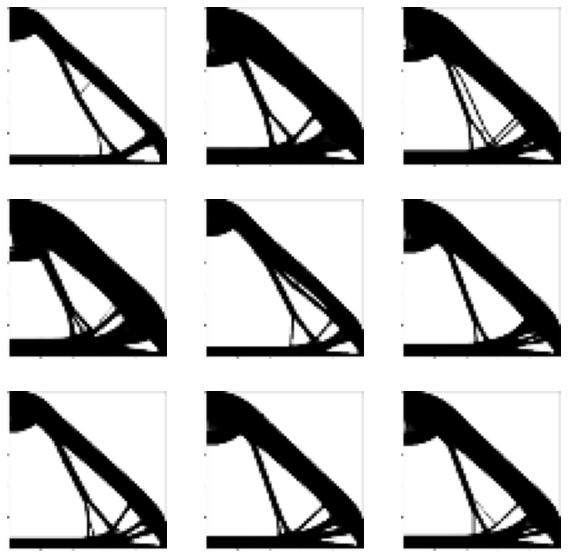

In [ ]:
# Visvalize the dataset
plt.figure(figsize=(10, 10))
for images in ds.take(1): #Take subsets the dataset into at most __1__ element (Seems to randomly create it)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images.numpy() # To convert to Numpy for plotting
        img = img.squeeze() # Since the image is resized to 128x12x1, we need to squeeze() to match the dimentions of imshow()
        # valid_imshow_data(images)
        plt.imshow(img[i], cmap='gray')
        plt.axis("off")

In [4]:
discriminator = keras.Sequential(
    [
     # Input Layer
     keras.Input(shape=(64,64,1), name='Disc_Input'),

     # Conv2D_Network_1
     layers.Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_initializer=kernal_init, use_bias=False),
     layers.LeakyReLU(0.2),

     # Conv2D_Network_2
     layers.Conv2D(64 * 2, kernel_size=4, strides=2, padding="same", kernel_initializer=kernal_init, use_bias=False),
     layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
     layers.LeakyReLU(0.2), 

     # Conv2D_Network_3
     layers.Conv2D(64 * 4, kernel_size=4, strides=2, padding="same", kernel_initializer=kernal_init, use_bias=False),
     layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
     layers.LeakyReLU(0.2),

     # Conv2D_Network_4
     layers.Conv2D(64 * 8, kernel_size=4, strides=2, padding="same", kernel_initializer=kernal_init, use_bias=False),
     layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
     layers.LeakyReLU(0.2),

     # Outut Layer
     layers.Flatten(),
     layers.Dropout(0.1),
     layers.Dense(1, activation='sigmoid')
    ],
    name="discriminator"
)

print(discriminator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524288    
                                                     

In [5]:
latent_dim = 128

generator = keras.Sequential(
    [
     layers.Input(shape=(latent_dim,), name="Gen_Input"),
     layers.Dense(1*1*128),
     layers.Reshape((1, 1, 128)),

     layers.Conv2DTranspose(64 * 8, kernel_size=4, strides=4, padding="same", kernel_initializer=kernal_init, use_bias=False),
     layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
     layers.ReLU(),

     layers.Conv2DTranspose(64 * 4, kernel_size=4, strides=2, padding="same", kernel_initializer=kernal_init, use_bias=False),
     layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
     layers.ReLU(),

     layers.Conv2DTranspose(64 * 2, kernel_size=4, strides=2, padding="same", kernel_initializer=kernal_init, use_bias=False),
     layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
     layers.ReLU(),

     layers.Conv2DTranspose(64 * 1, kernel_size=4, strides=2, padding="same", kernel_initializer=kernal_init, use_bias=False),
     layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
     layers.ReLU(),

     layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", kernel_initializer=kernal_init, use_bias=False, activation="linear")

    ],
    name="generator"
)

print(generator.summary())

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        1048576   
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        20

In [6]:
lr = 0.0001

opt_gen = keras.optimizers.Adam(learning_rate=lr)
opt_dis = keras.optimizers.Adam(learning_rate=lr)

loss_fn = keras.losses.BinaryCrossentropy()

In [ ]:
for epoch in range (100):
  for idx, real in enumerate(tqdm(ds)):
    batch_size = real.shape[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    fake = generator(random_latent_vectors)

    if idx % 100 == 0:
      img = keras.preprocessing.image.array_to_img(fake[0])
      img.save(f"{savepath}generated_{epoch}_{idx}_.png")

    with tf.GradientTape() as disc_tape:
      loss_disc_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
      loss_disc_fake = loss_fn(tf.zeros(batch_size, 1), discriminator(fake))
      loss_disc = (loss_disc_real + loss_disc_fake)/2
    
    grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
    opt_dis.apply_gradients(zip(grads, discriminator.trainable_weights))

    with tf.GradientTape() as gen_tape:
      fake = generator(random_latent_vectors)
      output = discriminator(fake)
      loss_gen = loss_fn(tf.ones(batch_size, 1), output)

    grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
    opt_gen.apply_gradients(zip(grads, generator.trainable_weights))
  print(f"Epoch: {epoch} - Gen_Loss: {loss_gen} - Dis_Loss: {loss_disc}")

In [ ]:
print(batch_size)
print(real.shape[0])

In [ ]:
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
size = (128, 128)
gen_img = generator(random_latent_vectors)
pil_img = keras.preprocessing.image.array_to_img(gen_img[0])
img = pil_img.resize(size)
img
img.save(f"{savepath}generated(s128, bs4, e150)_150.png")

In [ ]:
modelpath = f"{savepath}generator model_{epoch + 1}_{batch_size}"
print(modelpath)
keras.models.save_model(generator, modelpath, save_format='h5')